In [26]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from tqdm import tqdm
import medpy.metric as metric

import torch

import monai
from monai.data import DataLoader, Dataset
from monai.transforms.utils import allow_missing_keys_mode
from monai.transforms import BatchInverseTransform
from monai.networks.nets import DynUNet

In [30]:
device = "cpu"
seed = 0

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(True)


In [28]:
def read_acd_data(dataset_path: str = "/dtu/3d-imaging-center/courses/02510/data/ACDC17") -> list[dict]:
    """ Assumes the data is in patient00X folders etc. """
    return [
        {
            'image': str(path),                                 # the unlabeled volume file
            'label': str(path).replace(".nii.gz", "_gt.nii.gz"),# all the labeled data has _gt in the path
            'id': path.name.split(".")[0]                       # the file name without ending 
        }
        for path in sorted(Path(dataset_path).glob("*/*frame[0-9][0-9].nii.gz"))
    ]

In [29]:
all_files = read_acd_data()
print(all_files[0])

{'image': '/dtu/3d-imaging-center/courses/02510/data/ACDC17/patient001/patient001_frame01.nii.gz', 'label': '/dtu/3d-imaging-center/courses/02510/data/ACDC17/patient001/patient001_frame01_gt.nii.gz', 'id': 'patient001_frame01'}


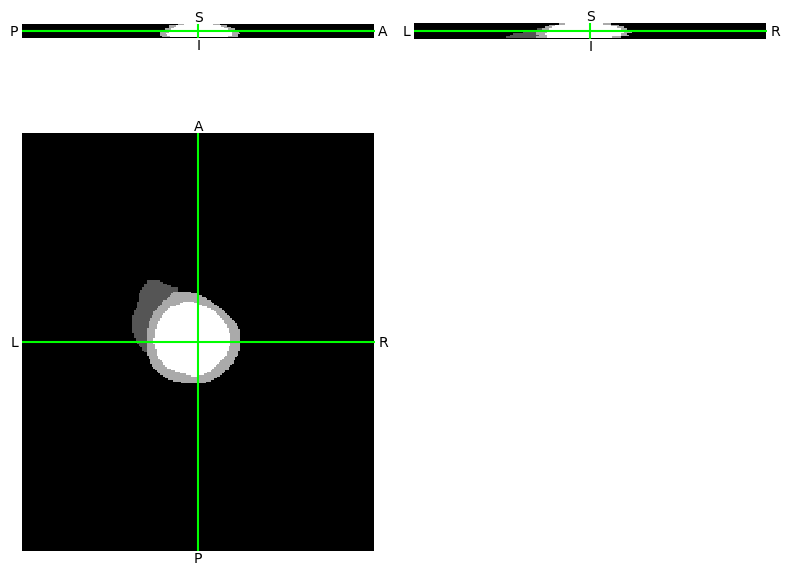

In [31]:
im = nib.load(all_files[0]['image'])
label = nib.load(all_files[0]['label'])
name = all_files[0]['id']

x,y,z = im.shape[0] // 2, im.shape[1] // 2, im.shape[2] // 2

plot = nib.viewers.OrthoSlicer3D(label.get_fdata(), title="Center slice of MRI data")
plot.set_position(x,y,z)
plt.tight_layout()
plot.show()

In [17]:
from torch.utils.data import random_split

transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    # TODO: Normalize for voxel/pixel size etc.
    # TODO: (Light) data augmentation
])

full_dataset = Dataset(data=all_files, transform=transforms)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, lengths = [0.7,0.1,0.2])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=1, shuffle=False) 
test_dataloader  = DataLoader(test_dataset, batch_size=1, shuffle=False) 

In [32]:
def count_parameters(model): 
    """ Get the number of params in a model. See: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = DynUNet(
    spatial_dims = 2,   # 2 for 2D convolutions, 3 for 3D convolutions
    in_channels  = 1,   # Number of input channels/modalities (3 for RGB)
    out_channels = 4,   # Number of classes, including background
    kernel_size  = [3, 3, 3, 3, 3, 3], # Size of the filters
    strides      = [1, 2, 2, 2, 2, 2],
    upsample_kernel_size = [2, 2, 2, 2, 2]
).to(device)

print(f"Num params: {count_parameters(model):_}")

Num params: 20_611_236


## Training

In [36]:
lr = 1e-3
n_epochs = 3

loss_fn = monai.losses.DiceLoss(softmax=True, to_onehot_y=False) # Apply "softmax" to the output of the network and don't convert to onehot because this is done already by the transforms.
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
inferer = monai.inferers.SliceInferer(roi_size=[-1, -1], spatial_dim=2, sw_batch_size=1)


for epoch in range(n_epochs):
    # Train
    model.train()

    for i, (image, label) in enumerate(train_dataloader):
        pass

    
    # Validate
    model.eval()
    for i, (image, label) in enumerate(val_dataloader):
        pass

    
    # Logging


## Plot results